# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (122.45, 123.75)
LAT_LIMITS = (-14.5, -13.3)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2023-06-01T00:00:00", "2023-07-03T00:00:00"]

crop_app = 'browse_basin_june23'

# # Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
# alldata_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'all')
# cropped_dir = os.path.join('/mnt', 'share', 'Other', 'Himawari', 'browse')
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [5]:
### Crop himawari files (optional)

# Setting ow=True will delete the original files after cropping (can also just set file_app='')
himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

Cropping file for time 20230531230000
Cropping file for time 20230601000000
Cropping file for time 20230601010000
Cropping file for time 20230601020000
Cropping file for time 20230601030000
Cropping file for time 20230601040000
Cropping file for time 20230601050000
Cropping file for time 20230601060000
Cropping file for time 20230601070000
Cropping file for time 20230601080000
Cropping file for time 20230601090000
Cropping file for time 20230601100000
Cropping file for time 20230601110000
Cropping file for time 20230601120000
Cropping file for time 20230601130000
Cropping file for time 20230601140000
Cropping file for time 20230601150000
Cropping file for time 20230601160000
Cropping file for time 20230601170000
Cropping file for time 20230601180000
Cropping file for time 20230601190000
Cropping file for time 20230601200000
Cropping file for time 20230601210000
Cropping file for time 20230601220000
Cropping file for time 20230601230000
Cropping file for time 20230602000000
Cropping fil

In [6]:
# Move the new files to another folder
move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
for mf in move_files:
    f_name = os.path.split(mf)[1]
    shutil.move(mf, os.path.join(cropped_dir, f_name))

In [7]:
# Load the data
ds = himawari.process_sst_series(cropped_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=2)
ds

  Finished processing for 2023-06-01T00:00:00
  Finished processing for 2023-06-01T01:00:00
  Finished processing for 2023-06-01T02:00:00
  Finished processing for 2023-06-01T03:00:00
  Finished processing for 2023-06-01T04:00:00
  Finished processing for 2023-06-01T05:00:00
  Finished processing for 2023-06-01T06:00:00
  Finished processing for 2023-06-01T07:00:00
  Finished processing for 2023-06-01T08:00:00
  Finished processing for 2023-06-01T09:00:00
  Finished processing for 2023-06-01T10:00:00
  Finished processing for 2023-06-01T11:00:00
  Finished processing for 2023-06-01T12:00:00
  Finished processing for 2023-06-01T13:00:00
  Finished processing for 2023-06-01T14:00:00
  Finished processing for 2023-06-01T15:00:00
  Finished processing for 2023-06-01T16:00:00
  Finished processing for 2023-06-01T17:00:00
  Finished processing for 2023-06-01T18:00:00
  Finished processing for 2023-06-01T19:00:00
  Finished processing for 2023-06-01T20:00:00
  Finished processing for 2023-06-

<xarray.Dataset> Size: 21MB
Dimensions:    (time: 674, lat: 30, lon: 33)
Coordinates:
  * time       (time) datetime64[s] 5kB 2023-06-01 ... 2023-07-02T23:00:00
  * lat        (lat) float64 240B -14.48 -14.44 -14.4 ... -13.4 -13.36 -13.32
  * lon        (lon) float64 264B 122.5 122.5 122.5 122.6 ... 123.7 123.7 123.7
    LON        (lat, lon) float64 8kB 122.5 122.5 122.5 ... 123.7 123.7 123.7
    LAT        (lat, lon) float64 8kB -14.48 -14.48 -14.48 ... -13.32 -13.32
    X          (lat, lon) float64 8kB -6.9e+04 -6.468e+04 ... 6.934e+04
    Y          (lat, lon) float64 8kB -6.417e+04 -6.417e+04 ... 6.417e+04
    lonc       float64 8B 123.1
    latc       float64 8B -13.9
    time_step  int64 8B 3600
Data variables:
    T          (time, lat, lon) float64 5MB 27.67 27.68 27.7 ... nan nan nan
    dTdt       (time, lat, lon) float64 5MB 1.979e-05 1.979e-05 ... nan nan
    dTdx       (time, lat, lon) float64 5MB 3.482e-06 3.769e-06 ... nan nan
    dTdy       (time, lat, lon) float64 5MB 9.604e-06 1.13e-05 ... nan nan

In [8]:
### Optional: save joined DS and delete individual cropped files
ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
# ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc')).sel(time=slice(time_lims[0], time_lims[1]))

### Uncomment to delete individual cropped files
# for mf in move_files:
#     f_name = os.path.split(mf)[1]
#     os.remove(os.path.join(cropped_dir, f_name))

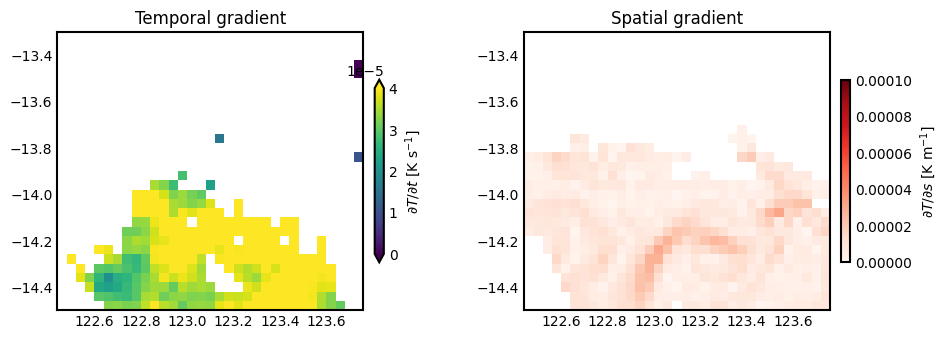

In [9]:
fig, ax = plots.plot_gradients(ds.isel(time=48), sg_names=['dTdx','dTdy'])

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:230: RuntimeWarning: All-NaN axis encountered
  new_vmin = np.nanmin(ds.isel(time=frame)[tg_name])
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:231: RuntimeWarning: All-NaN axis encountered
  new_vmax = np.nanmax(ds.isel(time=frame)[tg_name])
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:238: RuntimeWarning: All-NaN axis encountered
  new_vmin = np.nanmin(np.abs(ds.isel(time=frame)[sg_names[0]] + 1j*ds.isel(time=frame)[sg_names[1]]))
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:239: RuntimeWarning: All-NaN axis encountered
  new_vmax = np.nanmax(np.abs(ds.isel(time=frame)[sg_names[0]] + 1j*ds.isel(time=frame)[sg_names[1]]))


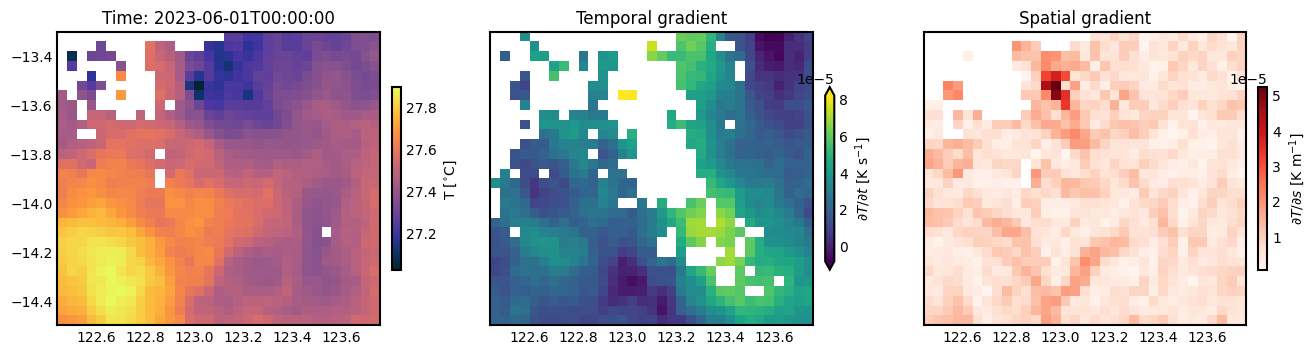

In [10]:
ani = plots.plot_data_animation(ds, anim_interval=100)
ani.save(f'{crop_app}_data_full.mp4')

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [11]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(10, 'h').astype('timedelta64[ns]')

results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_10h.nc'), callback='off', coverage=0.8)

Running GP optimization
Not enough data to fit
Saved results for time step 2023-06-01T00:00:00
Not enough data to fit
Saved results for time step 2023-06-01T01:00:00
Refitting hyperparameters
Saved results for time step 2023-06-01T02:00:00
Saved results for time step 2023-06-01T03:00:00
Saved results for time step 2023-06-01T04:00:00
Saved results for time step 2023-06-01T05:00:00
Saved results for time step 2023-06-01T06:00:00
Saved results for time step 2023-06-01T07:00:00
Saved results for time step 2023-06-01T08:00:00
Saved results for time step 2023-06-01T09:00:00
Saved results for time step 2023-06-01T10:00:00
Saved results for time step 2023-06-01T11:00:00
Not enough data to fit
Saved results for time step 2023-06-01T12:00:00
Not enough data to fit
Saved results for time step 2023-06-01T13:00:00
Not enough data to fit
Saved results for time step 2023-06-01T14:00:00
Not enough data to fit
Saved results for time step 2023-06-01T15:00:00
Not enough data to fit
Saved results for tim

In [12]:
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_10h.nc'))
ds_results.close()
ds_results

<xarray.Dataset> Size: 59kB
Dimensions:    (time: 674)
Coordinates:
  * time       (time) datetime64[ns] 5kB 2023-06-01 ... 2023-07-02T23:00:00
Data variables:
    sigma_u    (time) float64 5kB ...
    l_u        (time) float64 5kB ...
    tau_u      (time) float64 5kB ...
    sigma_v    (time) float64 5kB ...
    l_v        (time) float64 5kB ...
    tau_v      (time) float64 5kB ...
    sigma_S    (time) float64 5kB ...
    l_S        (time) float64 5kB ...
    tau_S      (time) float64 5kB ...
    sigma_tau  (time) float64 5kB ...

In [13]:
print("Calculating GP regression prediction")
ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results, coverage=0.8)
ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_10h.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_10h.nc'))

Calculating GP regression prediction


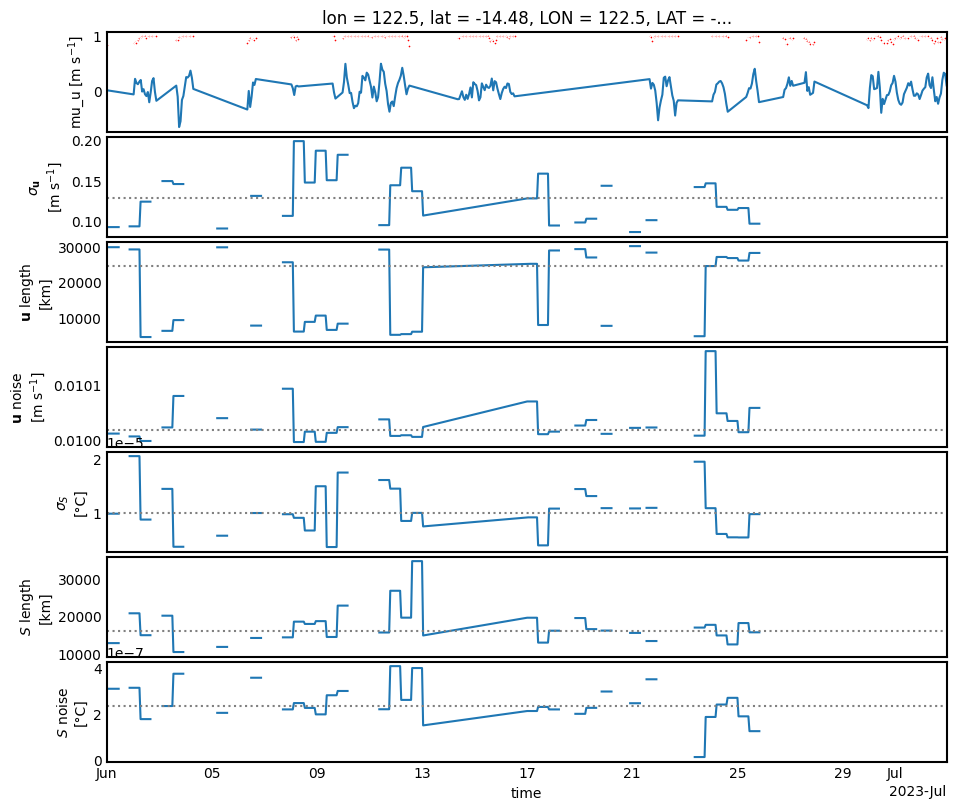

In [15]:
fig, ax = plots.plot_param_series(ds_results, ds_full)

In [16]:
ds_restrim = ds_results.copy()
ds_restrim = ds_restrim.dropna(dim='time')
ds_restrim = utils.clean_dataset(ds_restrim)
ds_restrim

<xarray.Dataset> Size: 3kB
Dimensions:    (time: 32)
Coordinates:
  * time       (time) datetime64[ns] 256B 2023-06-01T03:00:00 ... 2023-06-25T...
Data variables:
    sigma_u    (time) float64 256B 0.09267 0.09359 0.1239 ... 0.1161 0.09685
    l_u        (time) float64 256B 2.985e+04 2.922e+04 ... 2.608e+04 2.823e+04
    tau_u      (time) float64 256B 0.01001 0.01001 0.009997 ... 0.01001 0.01006
    sigma_v    (time) float64 256B 0.09267 0.09359 0.1239 ... 0.1161 0.09685
    l_v        (time) float64 256B 2.985e+04 2.922e+04 ... 2.608e+04 2.823e+04
    tau_v      (time) float64 256B 0.01001 0.01001 0.009997 ... 0.01001 0.01006
    sigma_S    (time) float64 256B 9.734e-06 2.056e-05 ... 5.264e-06 9.649e-06
    l_S        (time) float64 256B 1.276e+04 2.071e+04 ... 1.811e+04 1.564e+04
    tau_S      (time) float64 256B 3.067e-07 3.11e-07 ... 1.87e-07 1.226e-07
    sigma_tau  (time) float64 256B 0.004676 0.01131 ... 0.004605 0.003592

In [17]:
# If you prefer to have nan instead of missing time steps
ds_full_hourly = utils.make_even_hourly(ds_full)
ds_restrim_hourly = utils.make_even_hourly(ds_restrim)

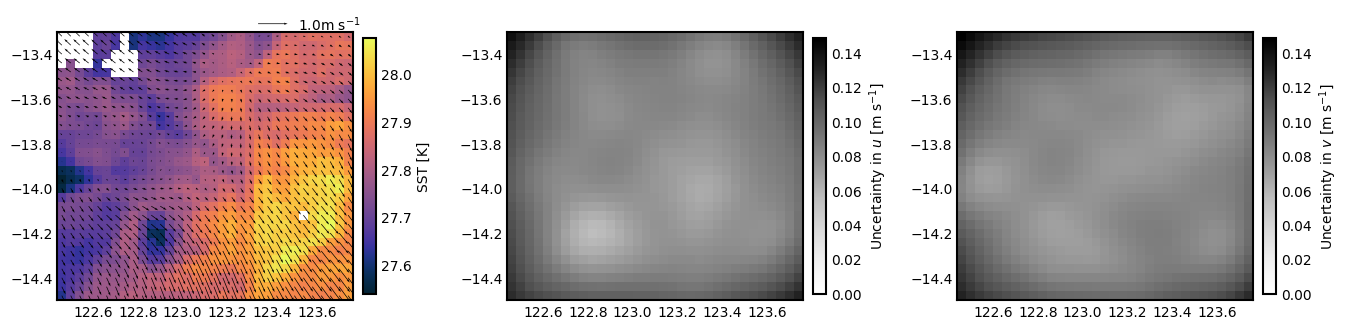

In [54]:
fig, ax = plots.plot_prediction(ds_full.isel(time=-28), qv_scale=10, qk_size=1.)

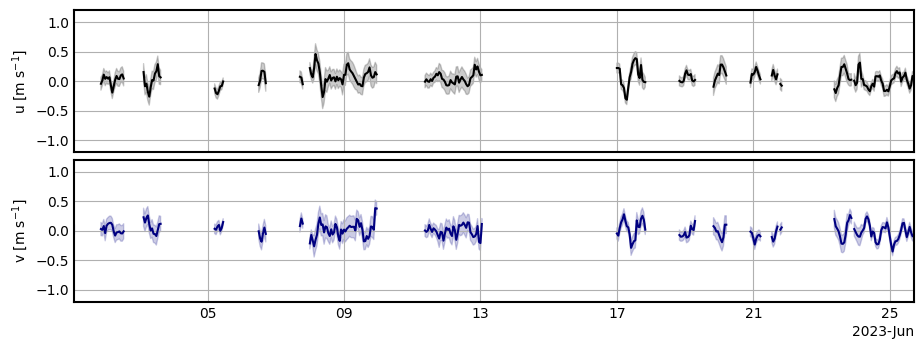

In [23]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=123.3744, lat_pt=-13.74942)
for x in ax:
    x.set_ylim(-1.21,1.21)
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(14,'D'))

## Some analysis

In [55]:
# import pIMOS.utils.catalogue as pcat

# # Load the DWR data
# exp = 'Shell'
# moor = 'DWR'
# exp_base = os.path.join(base_dir, 'Industry', exp, 'data', 'moored_instrument_data')

# cat = pcat.get_pimos_catalogue(exp_base, is_moored=True)

# # Load the most recent DWR file
# ds_dwr = xr.open_dataset(cat['nc_path'].loc[cat['Group']==moor].values[-1], decode_times=True)
# ds_dwr

In [56]:
import pandas as pd
from wootils.filters import check_spacing, filter1d_xr

ds_full_lp = ds_full_hourly.rolling(time=24, min_periods=20, center=True).mean()

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_7828/1989475004.py:17: SyntaxWarning: invalid escape sequence '\o'
  ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
/tmp/ipykernel_7828/1989475004.py:18: SyntaxWarning: invalid escape sequence '\o'
  ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')


Text(0, 0.5, '$\\overline{v}$ [m s$^{-1}$]')

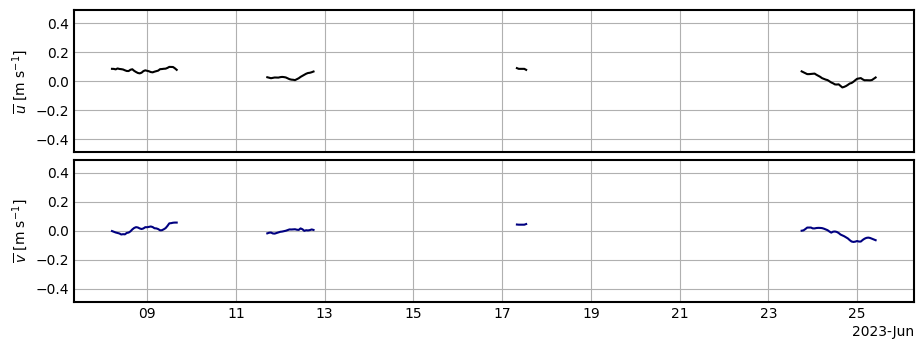

In [59]:
ds_point = ds_full_lp.sel(lon=123.3744, lat=-13.74942, method='nearest')

fig, ax = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={'hspace':0.05})

ds_point['mu_u'].plot(ax=ax[0], label='u velocity', c='k')

ds_point['mu_v'].plot(ax=ax[1], label='v velocity', c='navy')

for x in ax:
    x.set_xlabel('')
    x.set_title('')
    x.set_ylim(-0.49, 0.49)
    x.grid()
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

ax[0].set_xticklabels([])
ax[0].set_ylabel('$\overline{u}$ [m s$^{-1}$]')
ax[1].set_ylabel('$\overline{v}$ [m s$^{-1}$]')

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:301: RuntimeWarning: All-NaN axis encountered
  new_vmin = np.nanmin(ds.isel(time=frame)[T_name])
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:302: RuntimeWarning: All-NaN axis encountered
  new_vmax = np.nanmax(ds.isel(time=frame)[T_name])


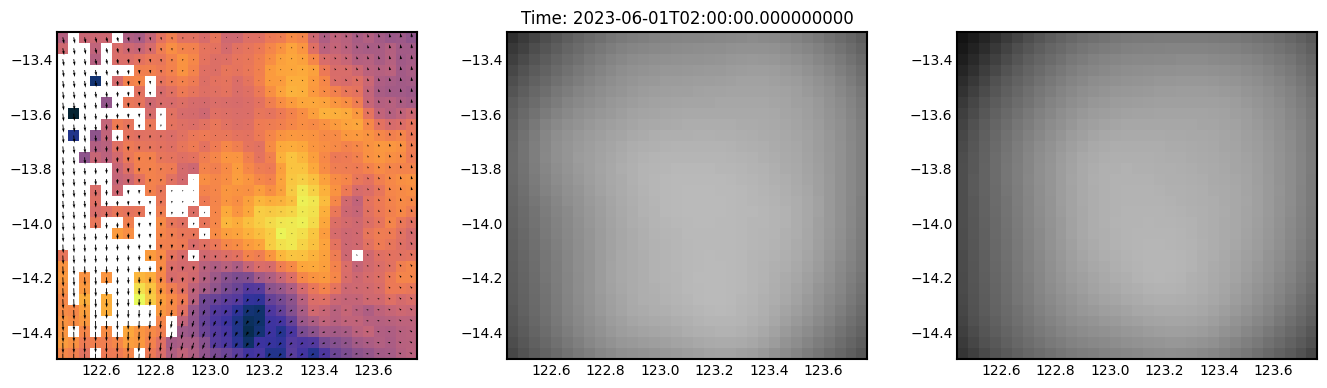

In [60]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full_hourly, qv_scale=14, anim_interval=100)
ani.save(f'{crop_app}_prediction_full.mp4')
# HTML(ani.to_jshtml())

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:301: RuntimeWarning: All-NaN axis encountered
  # Dynamically update the colormap limits based on the frame
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:302: RuntimeWarning: All-NaN axis encountered
  new_vmin = np.nanmin(ds.isel(time=frame)[T_name])


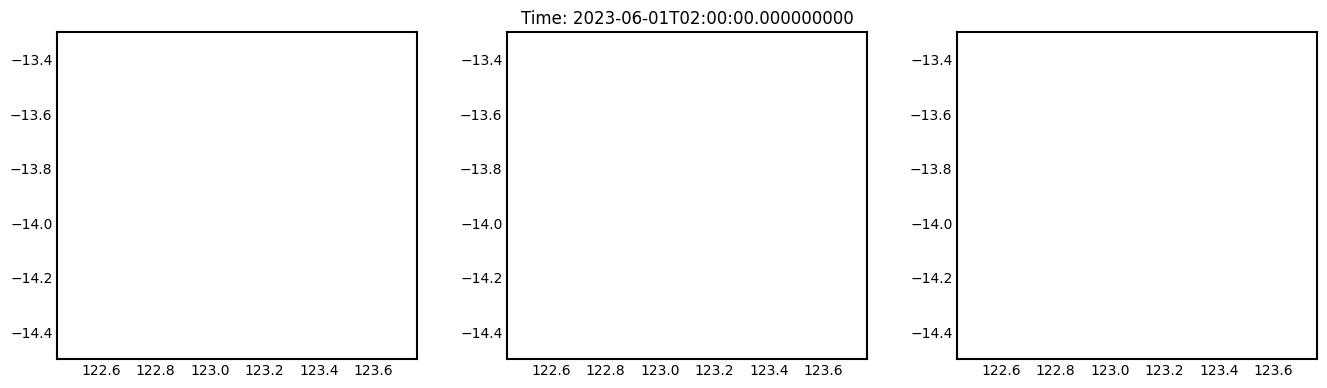

In [62]:
ani = plots.plot_prediction_animation(ds_full_lp, qv_scale=4, u_name='mu_u', v_name='mu_v', anim_interval=42)
ani.save(f'{crop_app}_prediction_lp.mp4')

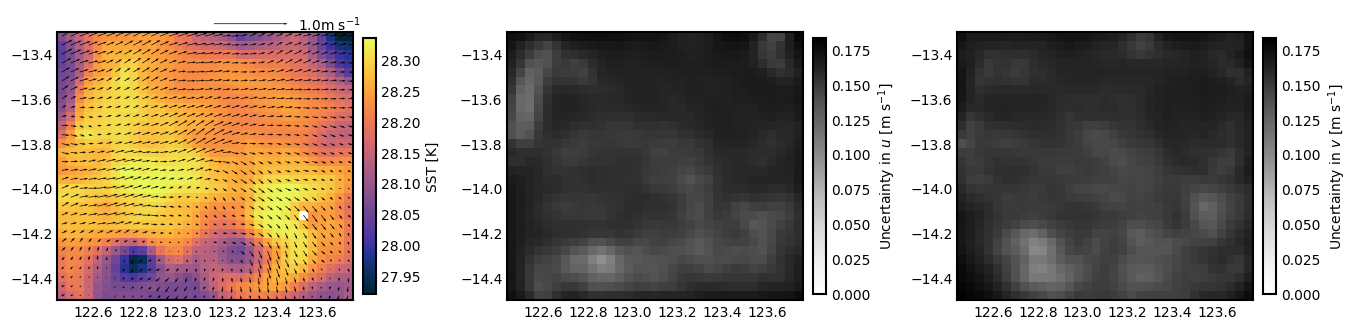

In [65]:
fig, ax = plots.plot_prediction(ds_full_lp.sel(time='2023-06-09T08'), qv_scale=4, qk_size=1.)

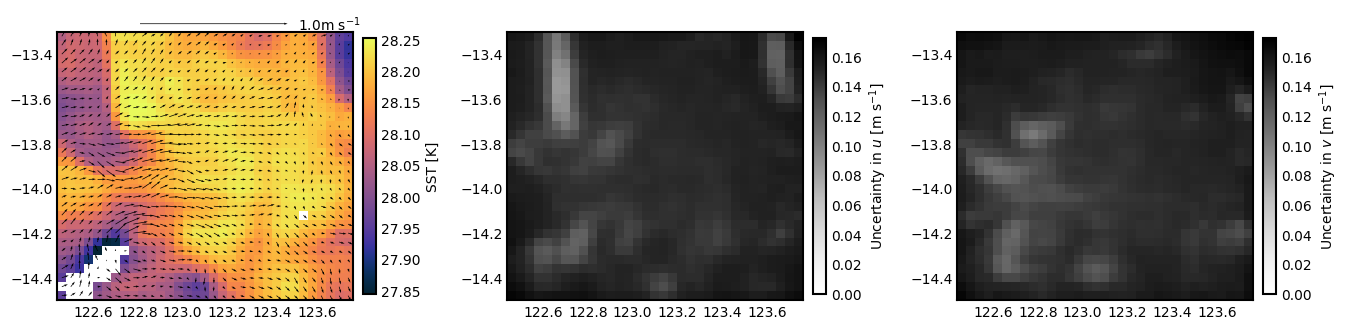

In [ ]:
fig, ax = plots.plot_prediction(ds_full_lp.sel(time='2023-06-12T13'), qv_scale=2, qk_size=0.2)

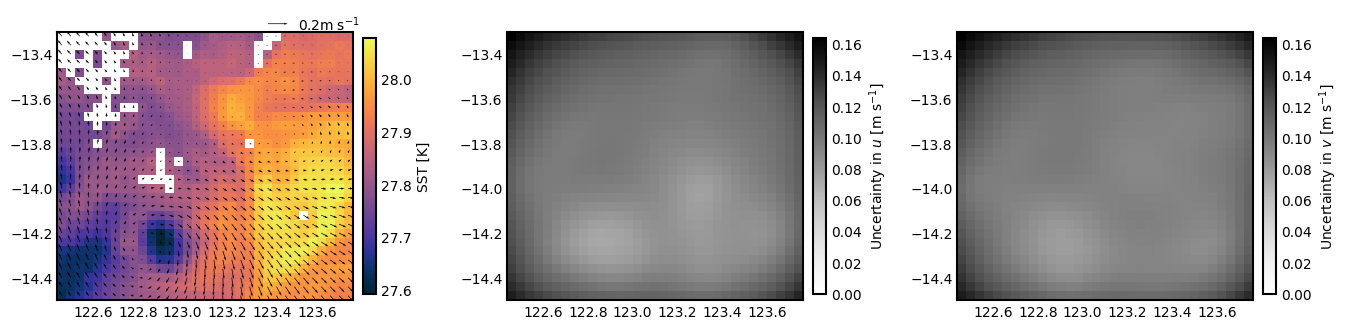

In [70]:
fig, ax = plots.plot_prediction(ds_full_lp.sel(time='2023-06-24T08'), qv_scale=3, qk_size=0.2)